<h2 align = "center">Mod 7: Dropout</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import latte
import latte.nn as nn
import latte.optim as optim
import latte.functional as F
import latte.utils.data as data

import lattevision as lv
import lattevision.datasets as dsets
import lattevision.transforms as T


In [2]:
mnist_root = '../data/mnist'
mnist_transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

mnist_train = dsets.MNIST(mnist_root, train=True, transform=mnist_transform)
mnist_test = dsets.MNIST(mnist_root, train=False, transform=mnist_transform)

val_len = len(mnist_train) // 10
train_len = len(mnist_train) - val_len
mnist_train, mnist_val = data.random_split(mnist_train, [train_len, val_len])

train_batch_size = 128
test_batch_size = 512

train_loader = data.DataLoader(mnist_train, batch_size=train_batch_size, shuffle=True)
val_loader = data.DataLoader(mnist_val, batch_size=train_batch_size, shuffle=False)
test_loader = data.DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False)


In [3]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class ModelDropout(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10, bias=False)

    def forward(self, x):
        out = self.fc1(x)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

    def set_to_eval(self):
        self.dropout.eval()

    def set_to_train(self):
        self.dropout.train()


model = Model()
model_dropout = ModelDropout()
criterion = nn.CrossEntropyLoss()
criterion_dropout = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0)
optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=1e-2, momentum=0)


In [4]:
max_epochs = 30

train_losses = []
train_losses_dropout = []
train_accuracies = []
train_accuracies_dropout = []

val_losses = []
val_losses_dropout = []
val_accuracies = []
val_accuracies_dropout = []

for epoch in range(max_epochs):
    # Training
    model_dropout.set_to_train()

    epoch_loss = 0
    epoch_loss_dropout = 0
    epoch_accuracy = 0
    epoch_accuracy_dropout = 0
    epoch_batchs = 0

    for ii, (data, target) in enumerate(train_loader):
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target = latte.Tensor(target)

        # Forward pass
        optimizer.zero_grad()
        optimizer_dropout.zero_grad()
        output = model(data)
        output_dropout = model_dropout(data)

        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.data
        loss_dropout = criterion_dropout(output_dropout, target)
        epoch_loss_dropout += loss_dropout.data

        # Backward pass
        loss.backward()
        optimizer.step()
        loss_dropout.backward()
        optimizer_dropout.step()

        # Compute accuracy
        accuracy = (output.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy += accuracy
        accuracy_dropout = (output_dropout.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy_dropout += accuracy_dropout

    # Logging
    train_losses.append(np.round(epoch_loss / epoch_batchs, 4))
    train_losses_dropout.append(np.round(epoch_loss_dropout / epoch_batchs, 4))
    train_accuracies.append(np.round(epoch_accuracy / epoch_batchs, 4))
    train_accuracies_dropout.append(np.round(epoch_accuracy_dropout / epoch_batchs, 4))

    # Validation
    model_dropout.set_to_eval()

    epoch_loss = 0
    epoch_loss_dropout = 0
    epoch_accuracy = 0
    epoch_accuracy_dropout = 0
    epoch_batchs = 0

    for data, target in val_loader:
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target = latte.Tensor(target)

        output = model(data)
        output_dropout = model_dropout(data)

        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.data
        loss_dropout = criterion_dropout(output_dropout, target)
        epoch_loss_dropout += loss_dropout.data

        # Compute accuracy
        accuracy = (output.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy += accuracy
        accuracy_dropout = (output_dropout.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy_dropout += accuracy_dropout

    # Logging
    val_losses.append(np.round(epoch_loss / epoch_batchs, 4))
    val_losses_dropout.append(np.round(epoch_loss_dropout / epoch_batchs, 4))
    val_accuracies.append(np.round(epoch_accuracy / epoch_batchs, 4))
    val_accuracies_dropout.append(np.round(epoch_accuracy_dropout / epoch_batchs, 4))

print('No Dropout:')
print('Training')
print(f'\tLoss: {train_losses}')
print(f'\tAccuracy: {train_accuracies}')
print('Validation')
print(f'\tLoss: {val_losses}')
print(f'\tAccuracy: {val_accuracies}')
print('Dropout:')
print('Training')
print(f'\tLoss: {train_losses_dropout}')
print(f'\tAccuracy: {train_accuracies_dropout}')
print('Validation')
print(f'\tLoss: {val_losses_dropout}')
print(f'\tAccuracy: {val_accuracies_dropout}')


No Dropout:
Training
	Loss: [1.2289, 0.4441, 0.3563, 0.3197, 0.2953, 0.2767, 0.2598, 0.2464, 0.2339, 0.2226, 0.2124, 0.203, 0.1939, 0.1854, 0.1783, 0.1706, 0.1639, 0.158, 0.1519, 0.1466, 0.1412, 0.1364, 0.1314, 0.1273, 0.1233, 0.1196, 0.1159, 0.1126, 0.1089, 0.106]
	Accuracy: [0.7472, 0.8814, 0.8991, 0.9093, 0.9151, 0.9203, 0.9255, 0.9295, 0.933, 0.9373, 0.9398, 0.9431, 0.9455, 0.9481, 0.9494, 0.9519, 0.9541, 0.9553, 0.9575, 0.9592, 0.961, 0.962, 0.9636, 0.965, 0.9662, 0.9672, 0.9682, 0.969, 0.9701, 0.971]
Validation
	Loss: [0.5355, 0.3711, 0.3199, 0.2958, 0.2724, 0.2564, 0.2412, 0.2318, 0.2185, 0.2095, 0.1999, 0.1922, 0.1834, 0.1776, 0.1706, 0.1643, 0.1577, 0.1544, 0.1489, 0.1451, 0.1394, 0.1356, 0.1322, 0.1285, 0.1247, 0.1215, 0.1188, 0.1172, 0.1136, 0.1114]
	Accuracy: [0.8703, 0.8962, 0.9097, 0.9161, 0.9236, 0.9266, 0.9311, 0.9325, 0.9358, 0.9382, 0.9392, 0.945, 0.9464, 0.9464, 0.95, 0.95, 0.9533, 0.9547, 0.9549, 0.9571, 0.9585, 0.9594, 0.9604, 0.9604, 0.9616, 0.962, 0.9625, 0.9623,

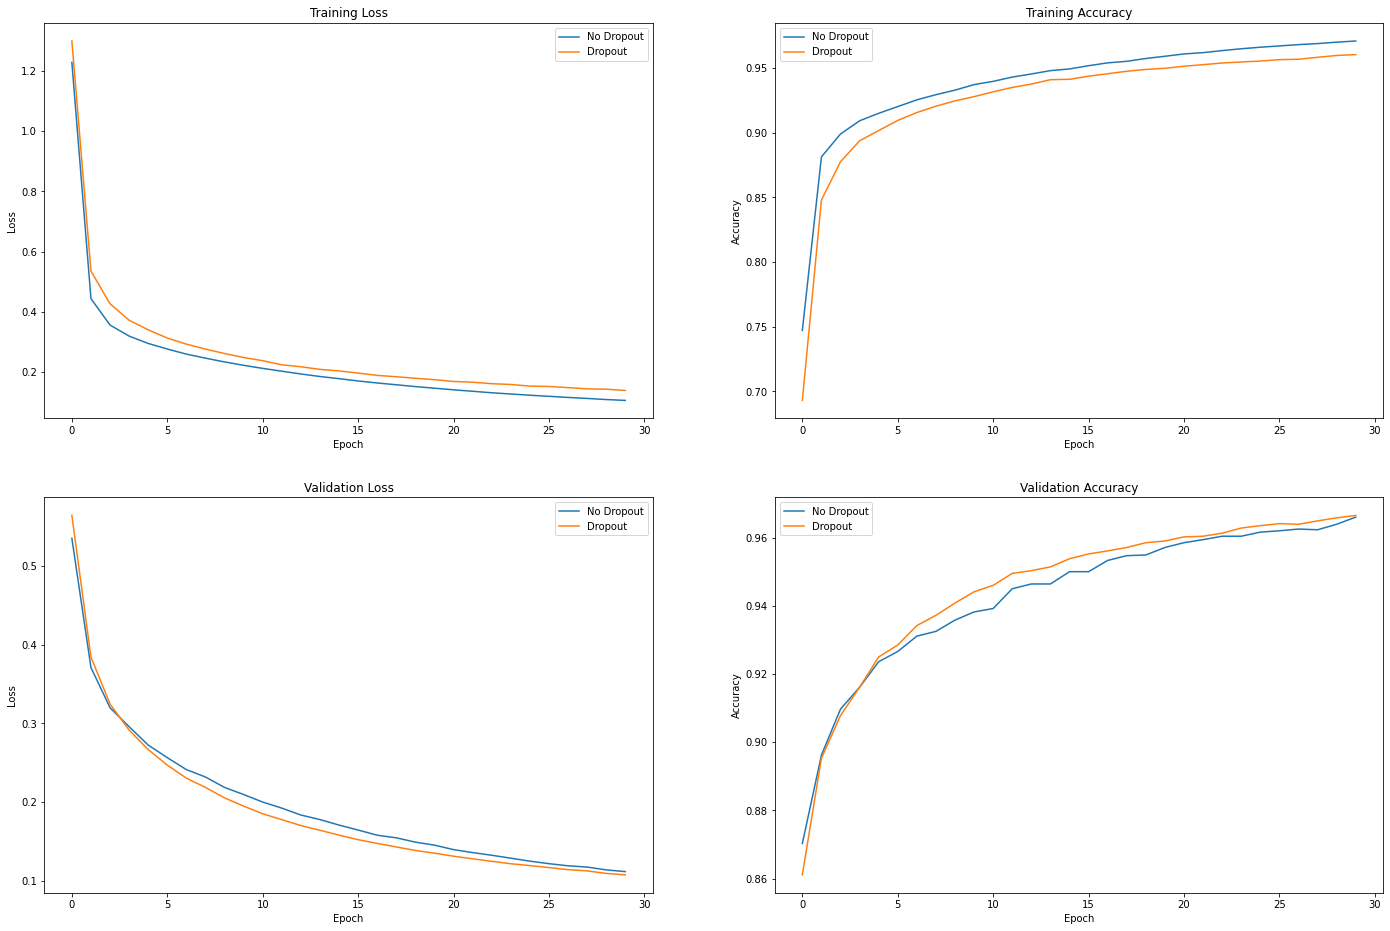

In [5]:
# Plot
plt.figure(figsize=(24, 16))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='No Dropout')
plt.plot(train_losses_dropout, label='Dropout')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='No Dropout')
plt.plot(train_accuracies_dropout, label='Dropout')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(val_losses, label='No Dropout')
plt.plot(val_losses_dropout, label='Dropout')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(val_accuracies, label='No Dropout')
plt.plot(val_accuracies_dropout, label='Dropout')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [6]:
# Test
model_dropout.set_to_eval()

correct = 0
correct_dropout = 0
total = 0
for data, target in test_loader:
    batch_size = data.shape[0]
    if batch_size != test_batch_size:
        continue

    data = latte.Tensor(data.reshape(batch_size, -1))
    target = latte.Tensor(target)

    output = model(data)
    output_dropout = model_dropout(data)
    correct += (output.data.argmax(axis=1) == target.data).sum()
    correct_dropout += (output_dropout.data.argmax(axis=1) == target.data).sum()
    total += target.shape[0]

print(f'Accuracy')
print(f'\tNo Dropout: {(correct / total): .4f}')
print(f'\tDropout: {(correct_dropout / total): .4f}')


Accuracy
	No Dropout:  0.9667
	Dropout:  0.9673
